 Initializations and Dataset Download

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: troshni
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 379MB/s]


*Imports*

In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


**Reading Data Paths**


The following code will be going through a nested directory structure where images are stored within subdirectories, each directory is representing a specific label (category). It constructs a list of the file paths for these images and their corresponding labels. Then, it creates a pandas DataFrame containing this information, which is useful for further data processing. Keep in mind that we will read all the data and then we will split it again to train, validation and testing.

In [3]:
image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("/content/animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.head() # Visualizing the first 5 rows

,image_paths,labels
0,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
1,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
2,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
3,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
4,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog


**Data Split**

Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using data_df.sample(frac=0.7,random_state=7) then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using data_df.drop(train.index). Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:

Training: 70%
Validation: 15%
Testing: 15%

In [4]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


**Preprocessing Objects**

Now lets create some preprocessing objects, first we start by LabelEncoder which converts string classes to numeric for example instead of having the classes as (cat, dog) it will be (0,1) because machines understands numbers only. Next we will create an object transform which will help us to preprocess images by converting all images to same size, converting them to tensors of type float and you can even do more with this object.

In [5]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)



**Custom Dataset Class**

Lets create a dataset class. Our class is a customized class on how we can our own dataset. The class inherits from the main Dataset class from PyTorch, then we overwrite some of the existing functions in that class. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main Dataset class with the concept of inheritance as mentioned. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the constructor function __init__ we are declaring and our dataframe which will have image_path and the labels. Then we are creating our own image preprocessing object which is transform that we talked about before. For our labels, we are declaring our labels with the label_encoder we declared before. Which means that we will convert our labels are changed from string to numeric classes using fit_tranform. We didn't read each image inside the constructor as reading images here will be so time consuming. However, we are reading each image, applying the preprocessing and returning it in the __getitem__ to read this specific image with its corresponding encoded label by their index and returns them.

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label


**Create Dataset Objects**

Now lets create 3 data objects, for training data, validation and testing respectively giving them our dataframes we created before together with the transform object that we created before. We will use the same transform object to make sure all images are preprocessed as they are.

In [7]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

**Visualize Images**

This cell is optional and will not affect the model accuracy. Here we are just visualizing 9 random images using matplotlib package.

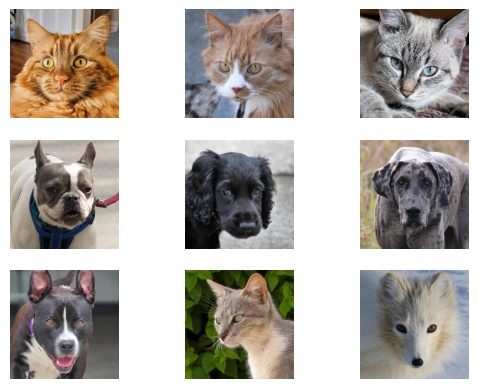

In [8]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

**Hyperparameters**

Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs and learning rate.

In [9]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

**DataLoaders**

PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


**Model**

Now we will build our CNN Network. We will be building it by creating a class that inherits from nn.Module and we will create our layers. Additionally, we will overwrite the forward function to modify our forward propagation. The model will start by having a 2-d convolution neural network that will have input channels of 3 which is the RGB input channels. Outputting 32 feature map. Then another 2-d convolution neural network taking 32 channels and outputting 64 and finally another one taking 64 channels and outputting 128 feature map. Each 2-d convolution neural network will be followed by a max pooling layer of size 2x2 and a ReLU activation function.

After that we will have a flatten layer to vectorize these feature maps followed by a linear layer which will have shape of (128, 16, 16) which means 128 feature map each one is 16x16 as the image started by 128x128 and got divided by 2 three times after each pooling layers. finally we will have an output linear layer with the length of the unique values of the labels.

In [11]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device



**Model Summary**

This cell is optional, here we show only the summary of the model and what is the output size for each layer. keep in mind that -1 here will be replaced by the batch size.

In [12]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

**Loss and Optimizer**

In the cell below, we will create the loss function which will be the Cross Entropy loss. Also we will have create the Adam optimizer and we will provide to it the parameters of the model we created.

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

**Training**

Now comes the training part. If you know well the training process of deep learning. You will just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs which we defined before. But before that we define 4 lists and inside the loop we define another 4 variables.



**Variables:**



*   **total_acc_train**: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.
*   **total_loss_train**: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

*   total_acc_val: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

* total_loss_val: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.





**Lists:**



*   total_acc_train_plot: We append the losses of the training accuracy to visualize them at the end.

* total_loss_train_plot: We append the losses of the training to visualize them at the end.

* total_acc_validation_plot: We append the losses of the validation accuracy to visualize them at the end.

* total_loss_validation_plot: We append the losses of the validation to visualize them at the end.



Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We add the loss amount to total_loss_train. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the total_acc_train. Then we do the batch_loss.backward() which makes the backpropagation and we use the optimizer to do a step on the weights using optimizer.step() and then we reset the optimizer gradients using optimizer.zero_grad() which is a very important step that has to be done before proceeding.

After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with torch.no_grad() so that we freeze the weights, which means that we need the model to do predicitons without being trained. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. Accuracies are calculated by dividing the right predictions by the complete number of samples and multiplying by 100. Losses are being divided by 1000 just to normalize the values and avoid large values.

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.3047 Train Accuracy 80.4092
              Validation Loss: 0.3691 Validation Accuracy: 90.9917
Epoch 2/10, Train Loss: 1.3922 Train Accuracy 92.6579
              Validation Loss: 0.2624 Validation Accuracy: 93.8017
Epoch 3/10, Train Loss: 0.9495 Train Accuracy 95.1909
              Validation Loss: 0.215 Validation Accuracy: 95.1653
Epoch 4/10, Train Loss: 0.6404 Train Accuracy 96.8559
              Validation Loss: 0.1747 Validation Accuracy: 96.0744
Epoch 5/10, Train Loss: 0.4948 Train Accuracy 97.3696
              Validation Loss: 0.2848 Validation Accuracy: 93.7603
Epoch 6/10, Train Loss: 0.3695 Train Accuracy 98.2198
              Validation Loss: 0.2047 Validation Accuracy: 96.0744
Epoch 7/10, Train Loss: 0.2834 Train Accuracy 98.5741
              Validation Loss: 0.2158 Validation Accuracy: 95.7438
Epoch 8/10, Train Loss: 0.1844 Train Accuracy 99.1409
              Validation Loss: 0.2138 Validation Accuracy: 95.9917
Epoch 9/10, Train Loss: 0.122 Tra

**Testing**

Now in this section, we will be testing our model, we will start the code by with torch.no_grad(): which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (cuda) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [15]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.5275 and Loss is 0.0182


**Plotting Training Progress**

Let's plot the training and validation progress through out the EPOCHS. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

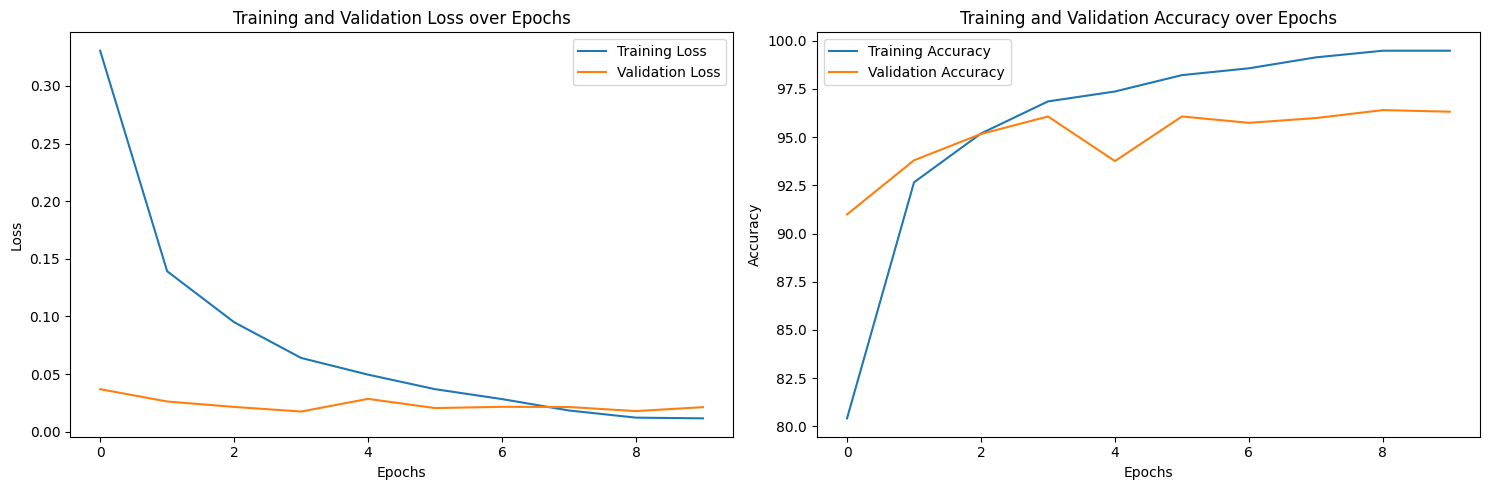

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

**Inference**

In the next cell, we will be doing the inference. We can get a random image from the internet and see the prediction of it. Again, the model may not be very good as the goal is to get used to PyTorch syntax. You can modify the model architecture and training loop and see the results.

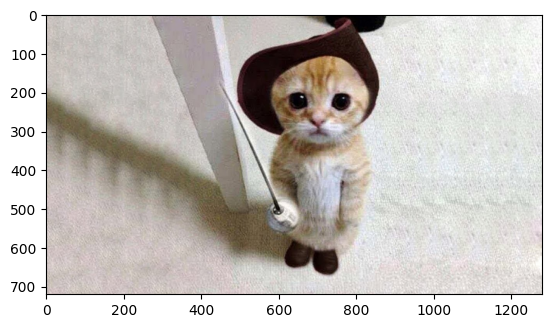


Prediction: 



array(['cat'], dtype=object)

In [18]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/hq720.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/hq720.jpg")
